### Imports

In [1]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, \
                                       ZeroPadding2D

from keras.optimizers import SGD, Adam, Adadelta
from keras.utils import np_utils
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import glob
#import cv2
import math
import pickle
import datetime
import pandas as pd
import glob

import os
import tensorflow as tf

Using TensorFlow backend.


### Read CSV into Notebook

In [2]:
with tf.Session() as sess:
  devices = sess.list_devices()
  print(devices)

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 6060841227723899648), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 11280557671, 6926195160784916976)]


In [3]:
csv_path = os.getcwd() + '/Distracted_Data/driver_imgs_list.csv'
d_csv = pd.read_csv(csv_path)
d_csv

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
5,p002,c0,img_3370.jpg
6,p002,c0,img_67639.jpg
7,p002,c0,img_58560.jpg
8,p002,c0,img_35779.jpg
9,p002,c0,img_10012.jpg


### Class Definitions

The 10 classes to predict are:  

c0: safe driving  
c1: texting - right  
c2: talking on the phone - right  
c3: texting - left  
c4: talking on the phone - left  
c5: operating the radio  
c6: drinking  
c7: reaching behind  
c8: hair and makeup  
c9: talking to passenger  

In [4]:
class_dict = {
    'c0': "safe driving",
    'c1': "texting - right",
    'c2': "talking on the phone - right",
    'c3': "texting - left",
    'c4': "talking on the phone - left ",
    'c5': "operating the radio ",
    'c6': "drinking",
    'c7': "reaching behind",
    'c8': "hair and makeup ",
    'c9': "talking to passenger ",
} 

### Read in Images

(480, 640, 3)


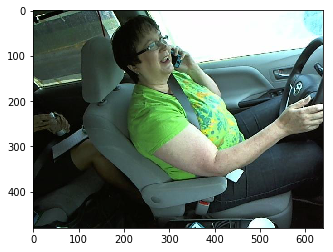

In [5]:
list_of_test_image_urls = glob.glob(os.getcwd() + '/Distracted_Data/imgs/test/*.*')

first_test_image = plt.imread(list_of_test_image_urls[100])

print(first_test_image.shape)
#list_of_test_image_urls[0]
plt.imshow(first_test_image)
plt.show()

### Build a Simple Keras Model

In [6]:
train_path = os.getcwd() + '/Distracted_Data/imgs/train/'

In [7]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

img_height = 224
img_width = 224
img_channels = first_test_image.shape[2]



#base_model = VGG19(weights='imagenet', include_top=False,input_shape=(img_height,img_width,img_channels))
base_model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_height,img_width,img_channels))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

(0, 'input_1', False)
(1, 'conv1_pad', False)
(2, 'conv1', False)
(3, 'bn_conv1', False)
(4, 'activation_1', False)
(5, 'pool1_pad', False)
(6, 'max_pooling2d_1', False)
(7, 'res2a_branch2a', False)
(8, 'bn2a_branch2a', False)
(9, 'activation_2', False)
(10, 'res2a_branch2b', False)
(11, 'bn2a_branch2b', False)
(12, 'activation_3', False)
(13, 'res2a_branch2c', False)
(14, 'res2a_branch1', False)
(15, 'bn2a_branch2c', False)
(16, 'bn2a_branch1', False)
(17, 'add_1', False)
(18, 'activation_4', False)
(19, 'res2b_branch2a', False)
(20, 'bn2b_branch2a', False)
(21, 'activation_5', False)
(22, 'res2b_branch2b', False)
(23, 'bn2b_branch2b', False)
(24, 'activation_6', False)
(25, 'res2b_branch2c', False)
(26, 'bn2b_branch2c', False)
(27, 'add_2', False)
(28, 'activation_7', False)
(29, 'res2c_branch2a', False)
(30, 'bn2c_branch2a', False)
(31, 'activation_8', False)
(32, 'res2c_branch2b', False)
(33, 'bn2c_branch2b', False)
(34, 'activation_9', False)
(35, 'res2c_branch2c', False)
(36, 'bn

In [9]:
batch_size=32
nb_epochs=5

In [10]:
import keras
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001), metrics=['accuracy'])

chkptk = keras.callbacks.ModelCheckpoint('ResNet_best_Frozen.h5',save_best_only = 'True')

#model = keras.models.load_model('bestdistracted.h5')

train_datagen = ImageDataGenerator(rescale=1./255,
    zoom_range=0.4,
    rotation_range=0.2, 
    height_shift_range= 0.4, 
    width_shift_range=0.4, 
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation') # set as validation data

history=model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    #samples_per_epoch = 15000,
    validation_data = validation_generator, 
    validation_steps=validation_generator.samples // batch_size,
    epochs = nb_epochs, verbose = 1,callbacks = [chkptk,keras.callbacks.EarlyStopping(monitor = 'val_loss',verbose = 1, patience = 5)])

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Epoch 1/5
560/560 [==============================] - 333s 594ms/step - loss: 1.6254 - acc: 0.4415 - val_loss: 2.5329 - val_acc: 0.1038
Epoch 2/5
560/560 [==============================] - 326s 583ms/step - loss: 1.0745 - acc: 0.6370 - val_loss: 2.5639 - val_acc: 0.1007
Epoch 3/5
560/560 [==============================] - 327s 583ms/step - loss: 0.9096 - acc: 0.6969 - val_loss: 2.7839 - val_acc: 0.1047
Epoch 4/5
560/560 [==============================] - 327s 584ms/step - loss: 0.7991 - acc: 0.7405 - val_loss: 2.6608 - val_acc: 0.1023
Epoch 5/5
560/560 [==============================] - 327s 584ms/step - loss: 0.7038 - acc: 0.7677 - val_loss: 2.6809 - val_acc: 0.0892


In [11]:
nb_epochs=50
for layer in model.layers[:250]:
   layer.trainable = False
for layer in model.layers[250:]:
   layer.trainable = True

In [12]:

sgd = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

chkptk = keras.callbacks.ModelCheckpoint('ResNet_best_UnFrozen.h5',save_best_only = 'True')

history2=model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps=validation_generator.samples // batch_size,
    epochs = nb_epochs, verbose = 1,callbacks = [chkptk,keras.callbacks.EarlyStopping(monitor = 'val_loss',verbose = 1, patience = 15)])
# Save the model

Epoch 1/50
560/560 [==============================] - 345s 616ms/step - loss: 0.6201 - acc: 0.8018 - val_loss: 2.6818 - val_acc: 0.0955
Epoch 2/50
560/560 [==============================] - 338s 603ms/step - loss: 0.6306 - acc: 0.7949 - val_loss: 2.6809 - val_acc: 0.0924
Epoch 3/50
560/560 [==============================] - 338s 603ms/step - loss: 0.6314 - acc: 0.7947 - val_loss: 2.6858 - val_acc: 0.0886
Epoch 4/50
560/560 [==============================] - 340s 607ms/step - loss: 0.6438 - acc: 0.7896 - val_loss: 2.6780 - val_acc: 0.0913
Epoch 5/50
560/560 [==============================] - 340s 607ms/step - loss: 0.6313 - acc: 0.7959 - val_loss: 2.6926 - val_acc: 0.0897
Epoch 6/50
560/560 [==============================] - 340s 606ms/step - loss: 0.6312 - acc: 0.7922 - val_loss: 2.6820 - val_acc: 0.0906
Epoch 7/50
560/560 [==============================] - 338s 604ms/step - loss: 0.6307 - acc: 0.7935 - val_loss: 2.6883 - val_acc: 0.0881
Epoch 8/50
560/560 [============================

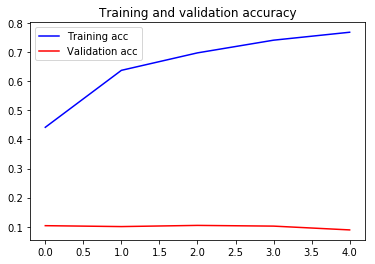

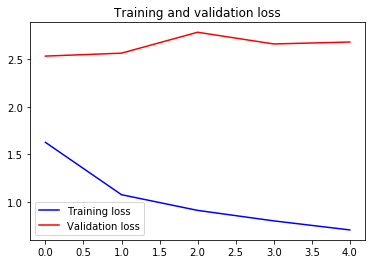

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [15]:
# Evaluate your model.
scores = model.evaluate_generator(validation_generator, steps=validation_generator.samples // batch_size)
print("Loss: " + str(scores[0]) + " Accuracy: " + str(scores[1]))

Loss: 2.675208378116799 Accuracy: 0.08990784445942908


In [16]:
import numpy
predictions = model.predict_generator(validation_generator, steps=(validation_generator.samples // batch_size)+1)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

In [17]:
from sklearn.metrics import log_loss
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys()) 
score = log_loss(validation_generator.classes, predictions)
score

2.679740028864463

Create sample submission

In [22]:
import glob
import matplotlib.pyplot as plt
import parmap
import cv2
test_globs = glob.glob(os.getcwd() + '/Distracted_Data/imgs/test/*.*')
file_names = [x.split('/')[-1] for x in test_globs]

batch_size1 = 10000

def getmatrix(x):
    return cv2.resize(plt.imread(x)/255.0, (224, 224))

predictions_kaggle = []

for i in range(0,len(test_globs),batch_size1):
    print('Processing {} to {} and length of predictions before append is {}'.format(i,i+batch_size1,len(predictions_kaggle)))
    X_test = []
    X_test.append(parmap.map(getmatrix,test_globs[i:i+batch_size1],pm_chunksize = 100))
    X_test = np.array(X_test[0])
    print(len(X_test))
    for image in X_test:
        predictions_kaggle.append(model.predict(image.reshape(-1,224, 224,3))[0])

Processing 0 to 10000 and length of predictions before append is 0
10000
Processing 10000 to 20000 and length of predictions before append is 10000
10000
Processing 20000 to 30000 and length of predictions before append is 20000
10000
Processing 30000 to 40000 and length of predictions before append is 30000
10000
Processing 40000 to 50000 and length of predictions before append is 40000
10000
Processing 50000 to 60000 and length of predictions before append is 50000
10000
Processing 60000 to 70000 and length of predictions before append is 60000
10000
Processing 70000 to 80000 and length of predictions before append is 70000
9726


In [23]:
c0 = []
c1 = []
c2 = []
c3 = []
c4 = []
c5 = []
c6 = []
c7 = []
c8 = []
c9 = []
for i in range(len(predictions_kaggle)):
    c0.append(predictions_kaggle[i][0])
    c1.append(predictions_kaggle[i][1])
    c2.append(predictions_kaggle[i][2])
    c3.append(predictions_kaggle[i][3])
    c4.append(predictions_kaggle[i][4])
    c5.append(predictions_kaggle[i][5])
    c6.append(predictions_kaggle[i][6])
    c7.append(predictions_kaggle[i][7])
    c8.append(predictions_kaggle[i][8])
    c9.append(predictions_kaggle[i][9])
    
submission_dict = {'img':file_names,'c0':c0,'c1':c1,'c2':c2,'c3':c3,'c4':c4,'c5':c5,'c6':c6,'c7':c7,'c8':c8,'c9':c9}

submission_df = pd.DataFrame(submission_dict)

submission_df = submission_df[[u'img',u'c0', u'c1', u'c2', u'c3', u'c4', u'c5', u'c6', u'c7', u'c8', u'c9']]

submission_df.to_csv('Resnet_submission.csv',index = False)